<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#005097; border:0' role="tab" aria-controls="home"><center>APRENDIZADO DE MÁQUINA (CIC1205/GCC1932) - Trabalho 1</center></h1>

- Nome completo: <ALEXANDER_RAMOS_FEITOSA>
- [Link para vídeo](<LINK_VIDEO>)

# (1) Predição de pagamento de empréstimos

### Análise exploratória dos conjuntos de treino e teste

=== Análise dos Conjuntos de Dados ===

Informações do conjunto de treinamento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ESCT     1500 non-null   int64
 1   NDEP     1500 non-null   int64
 2   RENDA    1500 non-null   int64
 3   TIPOR    1500 non-null   int64
 4   VBEM     1500 non-null   int64
 5   NPARC    1500 non-null   int64
 6   VPARC    1500 non-null   int64
 7   TEL      1500 non-null   int64
 8   IDADE    1500 non-null   int64
 9   RESMS    1500 non-null   int64
 10  ENTRADA  1500 non-null   int64
 11  CLASSE   1500 non-null   int64
dtypes: int64(12)
memory usage: 140.8 KB
None

Informações do conjunto de teste:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ESCT     577 non-null    int64
 1   NDEP     5

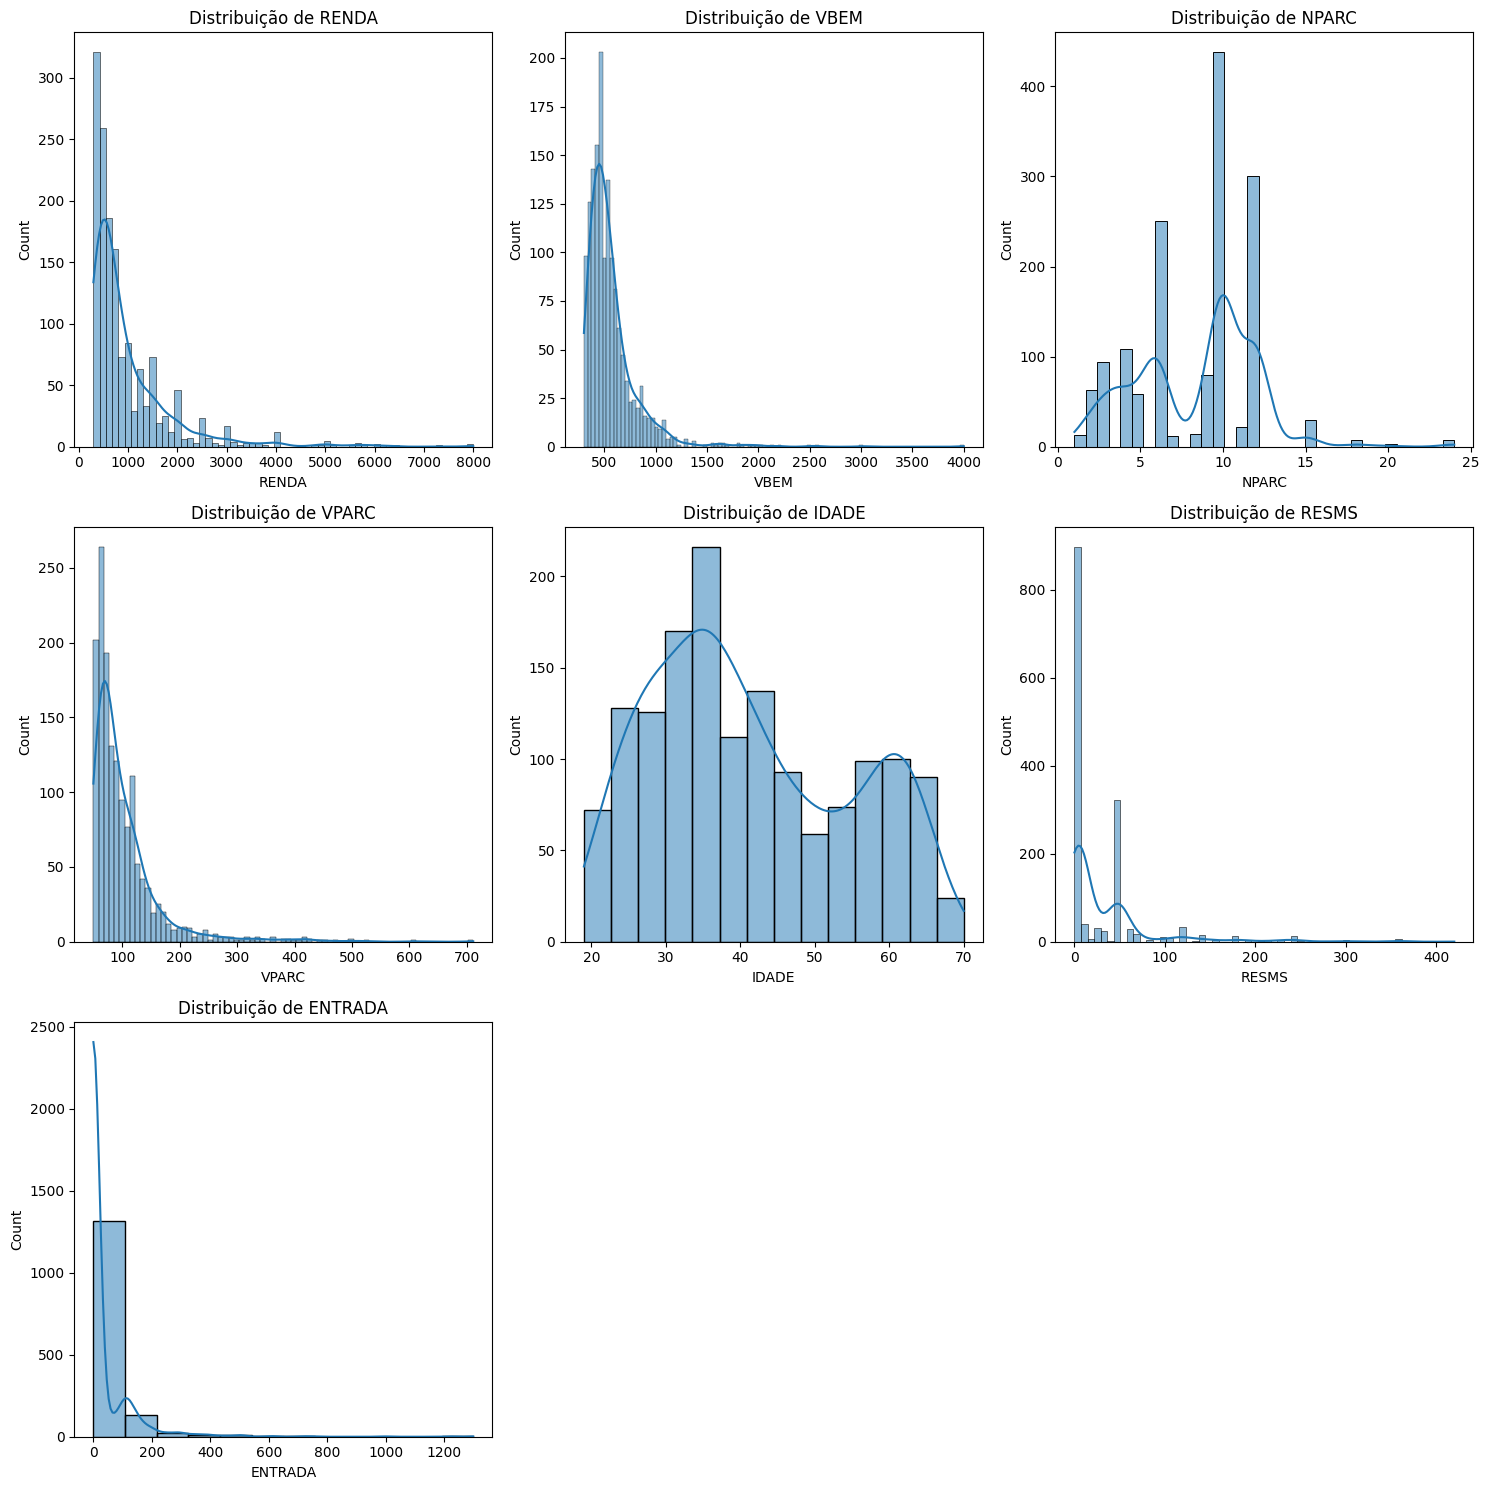

In [ ]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, classification_report

# Definição do dicionário de dados
column_mapping = {
    0: "ESCT",    # Estado civil
    1: "NDEP",    # Número de dependentes
    2: "RENDA",   # Renda Familiar
    3: "TIPOR",   # Tipo de residência
    4: "VBEM",    # Valor do bem a ser adquirido
    5: "NPARC",   # Número de parcelas
    6: "VPARC",   # Valor da parcela
    7: "TEL",     # Se possui telefone
    8: "IDADE",   # Idade do cliente
    9: "RESMS",   # Tempo de moradia (meses)
    10: "ENTRADA", # Valor da entrada
    11: "CLASSE"  # Cliente pagou a dívida (1=sim)
}

# Leitura dos arquivos
train_path = "data/credtrain.txt"
test_path = "data/credtest.txt"

# Leitura com nomes das colunas
df_train = pd.read_csv(train_path, sep="\t", header=None).rename(columns=column_mapping)
df_test = pd.read_csv(test_path, sep="\t", header=None).rename(columns=column_mapping)

# Análise exploratória inicial
print("=== Análise dos Conjuntos de Dados ===")
print("\nInformações do conjunto de treinamento:")
print(df_train.info())

print("\nInformações do conjunto de teste:")
print(df_test.info())

# Verificação do balanceamento das classes
print("\n=== Distribuição das Classes ===")
print("\nConjunto de treinamento:")
print(df_train["CLASSE"].value_counts(normalize=True).round(3))
print("\nConjunto de teste:")
print(df_test["CLASSE"].value_counts(normalize=True).round(3))

# Análise das distribuições das variáveis numéricas
numerical_cols = ["RENDA", "VBEM", "NPARC", "VPARC", "IDADE", "RESMS", "ENTRADA"]

# Criar subplots para cada variável numérica
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# Plotar distribuições
for idx, col in enumerate(numerical_cols):
    sns.histplot(data=df_train, x=col, ax=axes[idx], kde=True)
    axes[idx].set_title(f'Distribuição de {col}')
    axes[idx].set_xlabel(col)

# Remover subplot extra
axes[-1].remove()
axes[-2].remove()

plt.tight_layout()
plt.show()


### Pré-processamento das variáveis categóricas

In [38]:
# Definição das variáveis categóricas
categorical_features = ['ESCT', 'TIPOR', 'TEL', 'NDEP']

# Copia dos dataframes para não modificar os originais
y_train = df_train['CLASSE'].copy()
y_test = df_test['CLASSE'].copy()
X_train_prep = df_train.drop('CLASSE', axis=1).copy()
X_test_prep = df_test.drop('CLASSE', axis=1).copy()

# One-Hot Encoding para todas as variáveis categóricas
ohe = OneHotEncoder(sparse_output=False, drop='first')

# Fit e transform no conjunto de treino
categorical_encoded = ohe.fit_transform(X_train_prep[categorical_features])

# Criar nomes para as novas colunas
feature_names = []
for i, feature in enumerate(categorical_features):
    categories = ohe.categories_[i][1:]
    feature_names.extend([f"{feature}_{cat}" for cat in categories])

# Adicionar colunas encoded ao DataFrame de treino
encoded_df_train = pd.DataFrame(categorical_encoded, columns=feature_names, index=X_train_prep.index)
X_train_prep = pd.concat([X_train_prep.drop(columns=categorical_features), encoded_df_train], axis=1)

# Transform no conjunto de teste
categorical_encoded_test = ohe.transform(X_test_prep[categorical_features])
encoded_df_test = pd.DataFrame(categorical_encoded_test, columns=feature_names, index=X_test_prep.index)
X_test_prep = pd.concat([X_test_prep.drop(columns=categorical_features), encoded_df_test], axis=1)

# Verificação das transformações
print("\n=== Resultado do Preprocessamento ===")
print(f"\nNúmero de features após one-hot encoding: {X_train_prep.shape[1]}")
print("\nNovas variáveis categóricas:")
print([col for col in X_train_prep.columns if any(f in col for f in categorical_features)])

# Exibição dos primeiros registros do DataFrame transformado
print("\n=== Primeiros 10 registros após transformação ===")
print(X_train_prep.head(10))

# Guardar os nomes das colunas para uso posterior
column_names = X_train_prep.columns.tolist()


=== Resultado do Preprocessamento ===

Número de features após one-hot encoding: 19

Novas variáveis categóricas:
['ESCT_1', 'ESCT_2', 'ESCT_3', 'TIPOR_1', 'TEL_1', 'NDEP_1', 'NDEP_2', 'NDEP_3', 'NDEP_4', 'NDEP_5', 'NDEP_6', 'NDEP_7']

=== Primeiros 10 registros após transformação ===
   RENDA  VBEM  NPARC  VPARC  IDADE  RESMS  ENTRADA  ESCT_1  ESCT_2  ESCT_3  \
0    360   313      9     52     25     48        0     1.0     0.0     0.0   
1    350   468     10     65     33      6        0     0.0     0.0     0.0   
2   1100   829      9    125     56     48        0     0.0     0.0     0.0   
3   3000   552     12     76     31     60        0     0.0     0.0     0.0   
4   1000   809     12    111     24      7        0     1.0     0.0     0.0   
5    300   331      6     74     41      0        0     0.0     0.0     0.0   
6    580   349     10     51     30      6        0     0.0     0.0     0.0   
7    300   416     10     64     48    108        0     0.0     0.0     0.0   
8 

### Pré-processamento das variáveis numéricas

In [ ]:
# Normalização das variáveis numéricas

# Definição das variáveis numéricas e seus respectivos scalers
numeric_features = {
    'standard': ['IDADE', 'NPARC'],  # Variáveis com distribuição aproximadamente normal
    'robust': ['RENDA', 'VBEM', 'VPARC', 'ENTRADA'],  # Variáveis com outliers
    'minmax': ['RESMS']  # Variável temporal com limite natural
}

# Copia dos dataframes já processados anteriormente
X_train_final = X_train_prep.copy()
X_test_final = X_test_prep.copy()

# Dicionário para armazenar os scalers
scalers = {}

# Aplicar StandardScaler
std_scaler = StandardScaler()
for col in numeric_features['standard']:
    scalers[col] = std_scaler
    X_train_final[col] = std_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = std_scaler.transform(X_test_final[[col]])

# Aplicar RobustScaler
rob_scaler = RobustScaler()
for col in numeric_features['robust']:
    scalers[col] = rob_scaler
    X_train_final[col] = rob_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = rob_scaler.transform(X_test_final[[col]])

# Aplicar MinMaxScaler
mm_scaler = MinMaxScaler()
for col in numeric_features['minmax']:
    scalers[col] = mm_scaler
    X_train_final[col] = mm_scaler.fit_transform(X_train_final[[col]])
    X_test_final[col] = mm_scaler.transform(X_test_final[[col]])

# Verificação dos intervalos de valores antes/depois da normalização
all_features = (numeric_features['standard'] + 
                numeric_features['robust'] + 
                numeric_features['minmax'])

print("\n=== Intervalos de valores antes/depois da normalização ===")
for feature in all_features:
    print(f"\nFeature: {feature}")
    print(f"Original     - min: {df_train[feature].min():10.2f}, max: {df_train[feature].max():10.2f}")
    print(f"Normalizado - min: {X_train_final[feature].min():10.2f}, max: {X_train_final[feature].max():10.2f}")
    print(f"Scaler usado: {scalers[feature].__class__.__name__}")


=== Intervalos de valores antes/depois da normalização ===

Feature: IDADE
Original     - min:      19.00, max:      70.00
Normalizado - min:      -1.68, max:       2.18
Scaler usado: StandardScaler

Feature: NPARC
Original     - min:       1.00, max:      24.00
Normalizado - min:      -2.05, max:       4.33
Scaler usado: StandardScaler

Feature: RENDA
Original     - min:     300.00, max:    8000.00
Normalizado - min:      -0.48, max:      10.03
Scaler usado: RobustScaler

Feature: VBEM
Original     - min:     300.00, max:    4000.00
Normalizado - min:      -0.91, max:      16.88
Scaler usado: RobustScaler

Feature: VPARC
Original     - min:      50.00, max:     711.00
Normalizado - min:      -0.63, max:      12.08
Scaler usado: RobustScaler

Feature: ENTRADA
Original     - min:       0.00, max:    1300.00
Normalizado - min:       0.00, max:    1300.00
Scaler usado: RobustScaler

Feature: RESMS
Original     - min:       0.00, max:     420.00
Normalizado - min:       0.00, max:       1

### Processamento e resultados com os modelos propostos

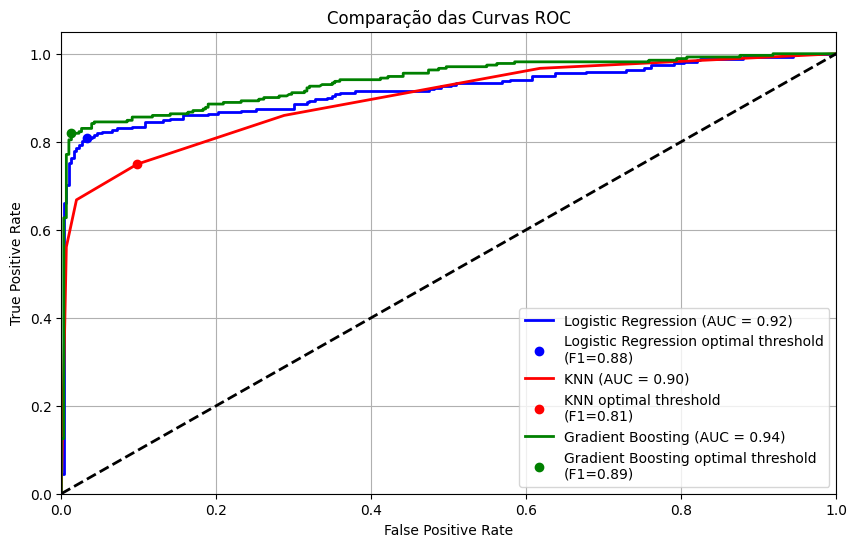

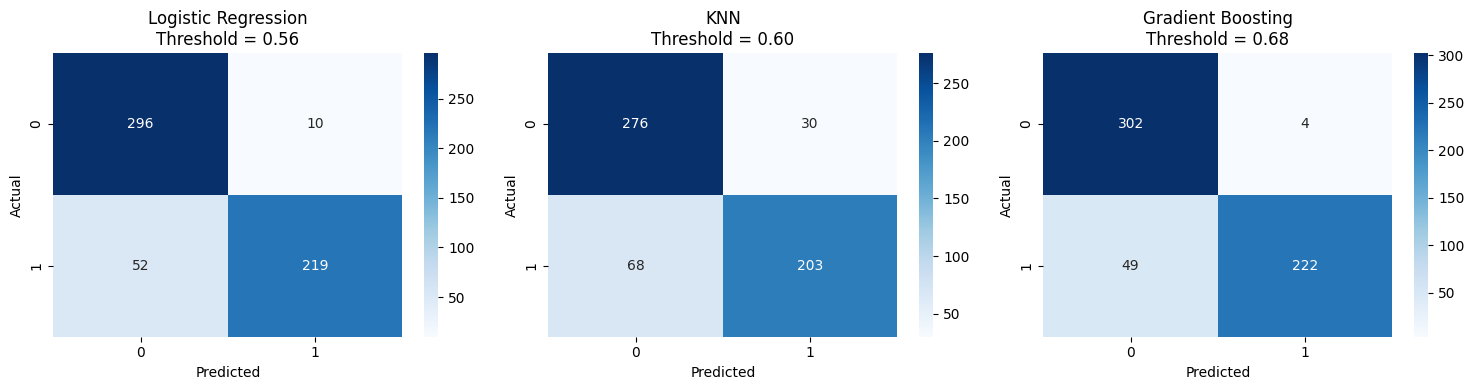


=== Classification Reports ===

Logistic Regression:
Threshold: 0.562
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       306
           1       0.96      0.81      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.90      0.89      0.89       577


KNN:
Threshold: 0.600
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       306
           1       0.87      0.75      0.81       271

    accuracy                           0.83       577
   macro avg       0.84      0.83      0.83       577
weighted avg       0.83      0.83      0.83       577


Gradient Boosting:
Threshold: 0.676
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       306
           1       0.98      0.82      0.89       271

    accuracy                           0.91       5

In [39]:
# Inicialização dos modelos
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dicionários para armazenar resultados
results = {}

# Criar figura única para todas as curvas ROC
plt.figure(figsize=(10, 6))

# Cores para cada modelo
colors = ['blue', 'red', 'green']

for (name, model), color in zip(models.items(), colors):
    # Treinar modelo
    model.fit(X_train_final, y_train)
    
    # Obter probabilidades de predição
    y_prob = model.predict_proba(X_test_final)[:, 1]
    
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Calcular F1-scores para diferentes limiares
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)
    
    # Encontrar limiar ótimo
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plotar curva ROC
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')
    
    # Marcar ponto do limiar ótimo
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'o', color=color,
             label=f'{name} optimal threshold\n(F1={f1_scores[optimal_idx]:.2f})')
    
    # Calcular predições com limiar ótimo
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    
    # Armazenar resultados
    results[name] = {
        'threshold': optimal_threshold,
        'predictions': y_pred_optimal,
        'confusion_matrix': confusion_matrix(y_test, y_pred_optimal),
        'classification_report': classification_report(y_test, y_pred_optimal)
    }

# Finalizar gráfico ROC
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparação das Curvas ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plotar matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, (name, result) in enumerate(results.items()):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\nThreshold = {result["threshold"]:.2f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Exibir classification reports
print("\n=== Classification Reports ===")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Threshold: {result['threshold']:.3f}")
    print(result['classification_report'])

# (2) Predição de preços de diamantes

### Análise exploratória da base fornecida

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Leitura do arquivo original
df = pd.read_csv('data/diamonds.csv')
df.info()
print (df.head(10))





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
   Unnamed: 0  carat        cut color clarity  depth  table  price     x  \
0           1   0.23      Ideal     E     SI2   61.5   55.0    326  3.95   
1           2   0.21    Premium     E     SI1   59.8   61.0    326  3.89   
2           3   0.23       Good     E     VS1   56.9   65.0    327  

### Pré-processamento com a codificação das variáveis categóricas, normalização das variáveis categóricas e  separação dos conjuntos de treino e teste

In [ ]:
# Preprocessamento dos dados
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Preparação dos dados
# Remove a coluna Unnamed: 0 e separa features de target
X = df.drop(['Unnamed: 0', 'price'], axis=1)

# Codifica variáveis categóricas
le = LabelEncoder()
X['cut'] = le.fit_transform(X['cut'])
X['color'] = le.fit_transform(X['color'])
X['clarity'] = le.fit_transform(X['clarity'])

# Usando MinMaxScaler para as variáveis numéricas
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Define o target (price)
y = df['price']

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_and_evaluate(X_train, y_train, X_test, y_test):
    """Treina e avalia os modelos de classificação"""



### Processamento e comparação dos resultados com os modelos propostos

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Inicializa os modelos
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Treina e avalia os modelos
results = {}
for name, model in models.items():
    # Treina o modelo
    print(f"\nTreinando {name}...")
    model.fit(X_train, y_train)
    
    # Faz previsões
    y_pred = model.predict(X_test)
    
    # Calcula métricas de desempenho
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
        
    # Armazena os resultados
    results[name] = {
        'R2': r2,
        'RMSE': rmse,
       
    }
    
    print(f"\nResultados para {name}:")
    print(f"RMSE: {rmse:.4f}")
    print(f"Coeficiente de Determinação: {r2:.4f}")

# Plotagem dos resultados
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name}\nR² = {results[name]["R2"]:.4f}')

plt.tight_layout()
plt.show()

# Plotagem dos resíduos
residuals = y_test - y_pred
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'{name} Residuals')
    plt.grid(True) 

plt.tight_layout()
plt.show()

# (3) Conjuntos desbalanceados - parte I

### Instruções iniciais 

In [ ]:
# Intruções Iniciais
import numpy as np
import pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

f = open('data/A652.pickle', 'rb')

(X_train, y_train, X_val, y_val, X_test, y_test) = pickle.load(f)
print(f"Shapes: ",X_train.shape, X_val.shape, X_test.shape)


# (4) Conjuntos desbalanceados - parte II

# (5) Calibração de modelos

# (6) Validação cruzada aninhada